In [1]:
# 基础模块
import os
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
from datetime import datetime
from collections import defaultdict

# 可视化配置
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.family'] = 'STHeiti'         # 中文支持（macOS）
plt.rcParams['axes.unicode_minus'] = False      # 正负号支持
%matplotlib inline

# 轨迹聚类与建模
from sklearn.cluster import DBSCAN
from pyproj import Transformer

# API调用（如POI增强）
import requests
import time
import json

# Neo4j 图数据库
from py2neo import Graph, Node, Relationship  # 若报错先注释，等后面阶段再装


# 路径配置
base_dir = os.path.dirname(os.path.abspath("__file__"))  # 当前脚本所在目录
root_dir = os.path.abspath(os.path.join(base_dir, '..'))  # 项目根目录
output_dir = os.path.join(root_dir, 'outputs')
traj_path = os.path.join(output_dir, 'geolife_cleaned_traj.csv')

已加载轨迹点数: 212806


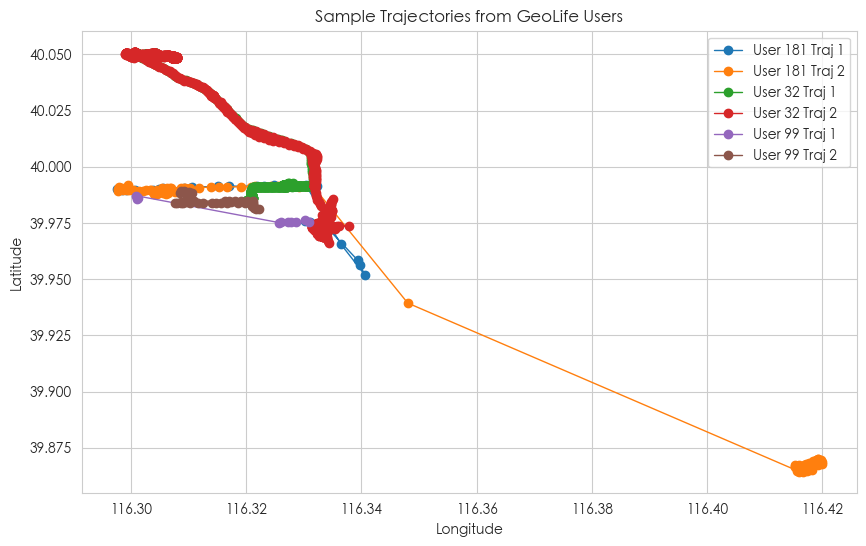

In [3]:
# ==========================================
# Trajectory Mining Based on GeoLife Dataset
# Stage 1: Load & Preview Cleaned Trajectory
# ==========================================

# 路径配置
base_dir = os.path.dirname(os.path.abspath("__file__"))  # 当前脚本所在目录
root_dir = os.path.abspath(os.path.join(base_dir, '..'))  # 项目根目录
output_dir = os.path.join(root_dir, 'outputs')
traj_path = os.path.join(output_dir, 'geolife_cleaned_traj.csv')

df = pd.read_csv(traj_path)
df['t'] = pd.to_datetime(df['t'])  # 转换时间格式
print("已加载轨迹点数:", len(df))
df.head()

# 可视化前几条轨迹
def plot_sample_trajectories(df, num_users=3):
    plt.figure(figsize=(10, 6))
    users = df['uid'].unique()[:num_users]
    for uid in users:
        sub = df[df['uid'] == uid]
        for tid in sub['traj_id'].unique()[:2]:
            traj = sub[sub['traj_id'] == tid]
            plt.plot(traj['x'], traj['y'], marker='o', linewidth=1, label=f"User {uid} Traj {tid}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title("Sample Trajectories from GeoLife Users")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_sample_trajectories(df)

In [3]:
df = pd.read_csv(traj_path)
coords = df[['x', 'y']].values

# === 聚类调参函数 ===
def clustering_summary(eps_list, min_samples_list):
    results = defaultdict(list)
    for eps in eps_list:
        for ms in min_samples_list:
            model = DBSCAN(eps=eps, min_samples=ms).fit(coords)
            labels = model.labels_
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            results['eps'].append(eps)
            results['min_samples'].append(ms)
            results['n_clusters'].append(n_clusters)
            results['n_noise'].append(n_noise)
    return pd.DataFrame(results)

# === 参数网格测试 ===
eps_list = [0.00005, 0.00006, 0.00007, 0.00008, 0.00009, 0.0001]
min_samples_list = [6, 8, 10, 12]

result_df = clustering_summary(eps_list, min_samples_list)
result_df.sort_values(by='n_clusters', ascending=False).reset_index(drop=True)

,eps,min_samples,n_clusters,n_noise
0,0.00006,6,2152,117106
1,0.00007,6,2118,108648
2,0.00008,6,2078,101523
3,0.00005,6,2035,127204
4,0.00009,6,2019,94810
5,0.00010,6,1930,89143
6,0.00009,8,1503,107021
7,0.00010,8,1474,101311
8,0.00008,8,1468,113469
9,0.00007,8,1455,120075


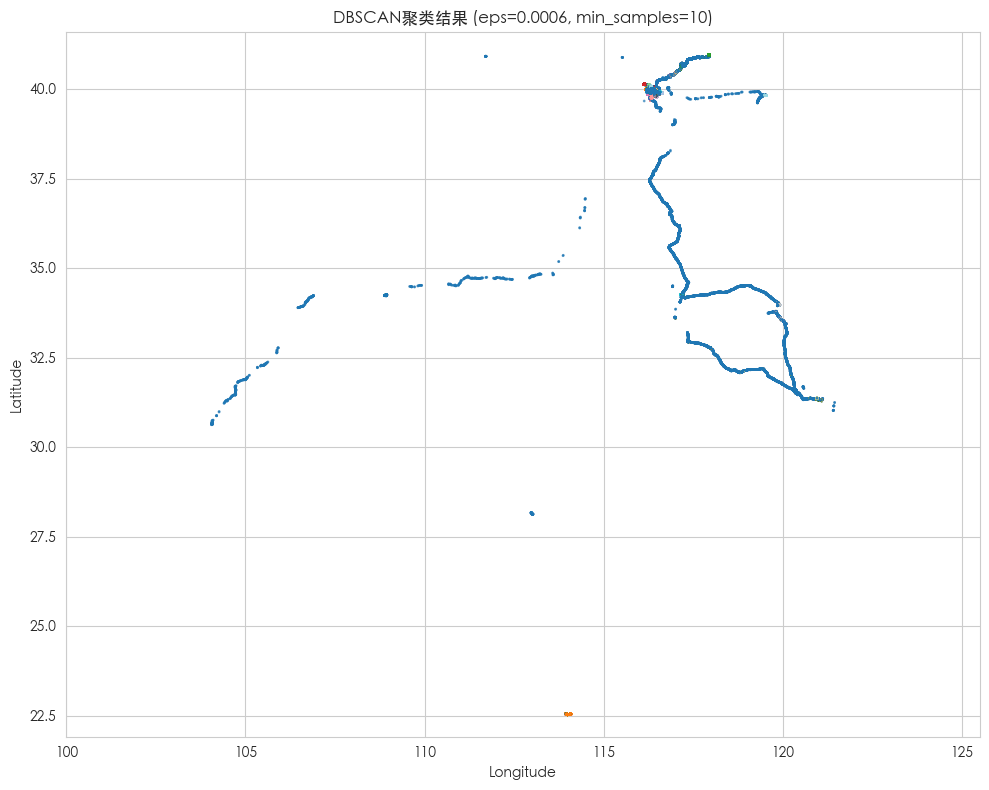

In [4]:
traj_df = pd.read_csv(traj_path)
coords = traj_df[["x", "y"]].values

# 聚类参数（基于测试最优参数）
eps = 0.0006
min_samples = 10

model = DBSCAN(eps=eps, min_samples=min_samples)
labels = model.fit_predict(coords)

plt.figure(figsize=(10, 8))
plt.scatter(coords[:, 0], coords[:, 1], c=labels, s=1, cmap='tab20', alpha=0.6)
plt.title(f'DBSCAN聚类结果 (eps={eps}, min_samples={min_samples})')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()

In [2]:
# 加载轨迹数据
traj_df = pd.read_csv(traj_path)
traj_df['t'] = pd.to_datetime(traj_df['t'])

# 空间聚类 (DBSCAN 参数可调)
coords = traj_df[['x', 'y']].values
dbscan = DBSCAN(eps=0.0004, min_samples=8).fit(coords)
traj_df['cluster'] = dbscan.labels_

# 提取簇的质心作为热点节点
nodes_df = traj_df[traj_df['cluster'] != -1].groupby('cluster')[['x', 'y']].mean().reset_index()
nodes_df.rename(columns={'cluster': 'node_id'}, inplace=True)

# 保存热点节点 nodes.csv
nodes_path = os.path.join(output_dir, 'nodes.csv')
nodes_df.to_csv(nodes_path, index=False)
print(f"节点提取完成，保存至: {nodes_path}")

节点提取完成，已保存至: /Users/chenenqiang/Desktop/Undergraduate Life/Undergraduate Life/创新实验2025春/FrequentPatternMiningBasedOnHotspotTrajectories/DataPreprocess/outputs/nodes.csv


In [3]:
nodes_path = os.path.join(output_dir, 'nodes.csv')

# 加载轨迹点和聚类中心
traj_df = pd.read_csv(traj_path)
nodes_df = pd.read_csv(nodes_path)

# 映射每个点到最近的 node_id
from sklearn.neighbors import KDTree

tree = KDTree(nodes_df[['x', 'y']].values)
points = traj_df[['x', 'y']].values
dists, indices = tree.query(points, k=1)

traj_df['node_id'] = indices.flatten()

print("轨迹点已成功映射为节点 ID（聚类中心）")
traj_df.head()

轨迹点已成功映射为节点 ID（聚类中心）


,uid,traj_id,t,x,y,node_id
0,181,1,2007-12-07 10:06:05,116.330267,39.976100,0
1,181,1,2007-12-07 10:14:29,116.331000,39.975417,0
2,181,1,2007-12-07 10:16:00,116.333133,39.975433,0
3,181,1,2007-12-07 10:17:56,116.339383,39.958367,0
4,181,1,2007-12-07 10:18:28,116.339783,39.956217,252


In [4]:
sequences = []
edges = defaultdict(lambda: {'frequency': 0, 'traj_ids': set()})

# 按用户和轨迹分组处理
grouped = traj_df.groupby(['uid', 'traj_id'])

for (uid, traj_id), group in grouped:
    group_sorted = group.sort_values('t')
    node_seq = group_sorted['node_id'].tolist()

    if len(node_seq) < 2:
        continue  # 跳过长度不足的轨迹

    # 构建边序列
    edge_seq = []
    for i in range(len(node_seq)-1):
        src, tgt = node_seq[i], node_seq[i+1]
        if src != tgt:  # 排除自环
            edge_seq.append([src, tgt])
            edges[(src, tgt)]['frequency'] += 1
            edges[(src, tgt)]['traj_ids'].add(f"{uid}_{traj_id}")

    sequences.append({
        'uid': uid,
        'traj_id': traj_id,
        'nodes': str(node_seq),
        'edges': str(edge_seq)
    })

# 保存轨迹序列文件
sequences_df = pd.DataFrame(sequences)
sequence_path = os.path.join(output_dir, 'traj_sequences.csv')
sequences_df.to_csv(sequence_path, index=False)
print(f"轨迹序列已保存至: {sequence_path}")

已保存：traj_sequences.csv
